
Classification of land cover
=======================================

# Objective
+ <b>To use scikit learn libraries to classify the Landsat image using python.</b>
+ <b>Learn about Random forest algorithm and implement it in python on satellite imagery.</b>



## What is a Random forest?
A brief explanation of the RandomForest algorithm comes from the name. Rather than utilize the predictions of a single decision tree, the algorithm will take the ensemble result of a large number of decision trees (a forest of them). The "Random" part of the name comes from the term "bootstrap aggregating", or "bagging". What this means is that each tree within the forest only gets to train on some subset of the full training dataset (the subset is determined by sampling with replacement). The elements of the training data for each tree that are left unseen are held "out-of-bag" for estimation of accuracy. Randomness also helps decide which feature input variables are seen at each node in each decision tree. Once all individual trees are fit to the random subset of the training data, using a random set of feature variable at each node, the ensemble of them all is used to give the final prediction. 

#### Based off of decision trees
![alt text](http://docsdrive.com/images/ansinet/itj/2009/fig3-2k8-5841.gif "Logo Title Text 1")


#### Forest: Collection of trees
![alt text](https://i.ytimg.com/vi/ajTc5y3OqSQ/hqdefault.jpg "Logo Title Text 1")



### But how do we construct the optimal tree? 

We use the Gini Index as our cost function used to evaluate splits in the dataset. We minimize it.

A split in the dataset involves one input attribute and one value for that attribute. It can be used to divide training patterns into two groups of rows.

A Gini score gives an idea of how good a split is by how mixed the classes are in the two groups created 
by the split. A perfect separation results in a Gini score of 0, whereas the worst case split that 
results in 50/50 classes in each group results in a Gini score of 1.0 (for a 2 class problem). We calculate it for every row and split the data accordingly in our binary tree. We repeat this process recursively. 

![alt text](https://image.slidesharecdn.com/decisiontree-151015165353-lva1-app6892/95/classification-using-decision-tree-41-638.jpg?cb=1444928106 "Logo Title Text 1")
 


### Advantages of Random Forest:
+ It gives you a measure of "variable important" which relates how useful your input features (e.g. spectral bands) were in the classification
+ The "out-of-bag" samples in each tree can be used to validate each tree. Grouping these predicted accuracies across all trees can [sometimes give you an unbiased estimate of the error rate](http://www.stat.berkeley.edu/~breiman/RandomForests/cc_home.htm#ooberr) similar to doing cross-validation.
+ Can be used for regressions, unsupervised clustering, or supervised classification
+ Available in many popular languages, including Python, R, and MATLAB
+ Free and open source, and fast



In the classification mode, this means that if you were to have 5 classes being predicted using 500 trees, the output prediction would be the class that has the most number of the 500 trees predicting it. The proportion of the number of trees that voted for the winning class can be a diagnostic of the representativeness of your training data relative to the rest of the image. Taking the 500 trees example, if you have pixels which are voted to be in the "Forest" land cover class by 475 of 500 trees, you could say that this was a relatively certain prediction. On the other hand, if you have a pixel which gets 250 votes for "Forest" and 225 votes for "Shrub", you could interpret this as either an innately confusing pixel (maybe it is a mixed pixel, or it is a small statured forest) or as an indicator that you need more training data samples in these types of pixels.



## Libraries used

- GDAL
- Numpy
- Matplotlib
- Scikit Learn

## Preparing the dataset
#### Opening the images
Reading in the example image and the ROI image 

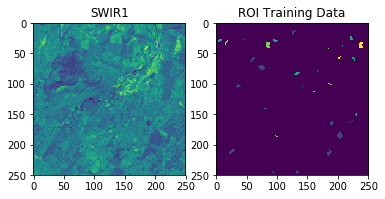

In [37]:
# Import Python 3's print function and division
#from __future__ import print_function, division

# Import GDAL, NumPy, and matplotlib
from osgeo import gdal, gdal_array
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Read in our image and ROI image
img_ds = gdal.Open('example/LE70220491999322EDC01_stack.gtif', gdal.GA_ReadOnly)
roi_ds = gdal.Open('example/training_data.gtif', gdal.GA_ReadOnly)

img = np.zeros((img_ds.RasterYSize, img_ds.RasterXSize, img_ds.RasterCount),
               gdal_array.GDALTypeCodeToNumericTypeCode(img_ds.GetRasterBand(1).DataType))
for b in range(img.shape[2]):
    img[:, :, b] = img_ds.GetRasterBand(b + 1).ReadAsArray()
    
roi = roi_ds.GetRasterBand(1).ReadAsArray().astype(np.uint8)

# Display them
plt.subplot(121)
plt.imshow(img[:, :, 4])
plt.title('SWIR1')

plt.subplot(122)
plt.imshow(roi)
plt.title('ROI Training Data')

plt.show()

### Preparing and cleaning data

In [38]:
from sklearn.model_selection import train_test_split

# bangalore_data_1D = bangalore_data_array.reshape(4198376,6)
# labael_bangalore_1D = labelBangalore.flatten()
features = img[roi > 0, :]
features = features[:,:7]
labels = roi[roi > 0]
print(features.shape)
print(labels.shape)


xTrain, xTest, yTrain, yTest = train_test_split(features, labels, test_size=0.4, random_state=42)


print(xTrain.shape)
print(xTest.shape)

(718, 7)
(718,)
(430, 7)
(288, 7)


## Training the Random Forest
Now that we have our X matrix of feature inputs (the spectral bands) and our y array (the labels), we can train our model.

Visit [this web page to find the usage of RandomForestClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) from `scikit-learn`.

In [39]:
from sklearn.ensemble import RandomForestClassifier

# Initialize our model with 500 trees
rf = RandomForestClassifier(n_estimators=500, oob_score=True)

# Fit our model to training data
rf = rf.fit(xTrain, yTrain)

#### Random Forest diagnostics

With our Random Forest model fit, we can check out the "Out-of-Bag" (OOB) prediction score:

In [40]:
print('Our OOB prediction of accuracy is: {oob}%'.format(oob=rf.oob_score_ * 100))

Our OOB prediction of accuracy is: 97.90697674418605%


To help us get an idea of which spectral bands were important, we can look at the feature importance scores:

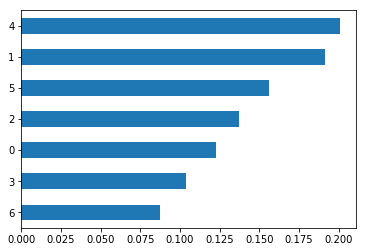

In [41]:
import pandas as pd
feature_importance = pd.Series(rf.feature_importances_).sort_values()
feature_importance.plot(kind='barh')

In [42]:
y_predict = rf.predict(xTest)

With the largest weights, it looks like the SWIR1 and the Green bands were the most useful to us. Not surprising, the thermal band is not very useful because there isn't much delineation of land cover type with temperature if you only look with a very small area not influenced by Urban Heat Island.

Let's look at a crosstabulation to see the class confusion. To do so, we will import the [Pandas](http://pandas.pydata.org/) library for some help:

In [43]:
from sklearn.metrics import confusion_matrix,classification_report
conf_mat = confusion_matrix(yTest,y_predict)

print(conf_mat)
print(classification_report(yTest,y_predict))

[[152   0   0   0   0]
 [  0   3   0   0   0]
 [  0   0  66   0   0]
 [  0   0   0  43   2]
 [  0   0   0   4  18]]
              precision    recall  f1-score   support

           1       1.00      1.00      1.00       152
           2       1.00      1.00      1.00         3
           3       1.00      1.00      1.00        66
           4       0.91      0.96      0.93        45
           5       0.90      0.82      0.86        22

   micro avg       0.98      0.98      0.98       288
   macro avg       0.96      0.95      0.96       288
weighted avg       0.98      0.98      0.98       288



### Cross Validation

[  1  11  21  31  41  51  61  71  81  91 101 111 121 131 141 151 161 171
 181 191 201 211 221 231 241 251 261 271 281 291 301 311 321 331 341 351
 361 371 381 391 401 411 421 431 441 451 461 471 481 491]


/home/nilay/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:458: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/nilay/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:463: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/home/nilay/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:458: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/nilay/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:463: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/home/nilay/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:458: UserWarning: Some inputs do no

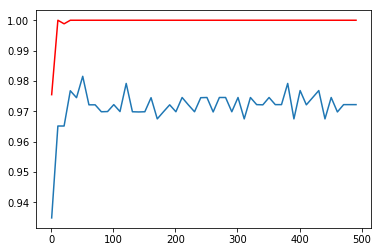

In [44]:
from sklearn.model_selection import validation_curve
param_range = np.arange(1,500,10)
print(param_range)
train_score,test_score = validation_curve(rf,xTrain,yTrain,
                                          param_name='n_estimators',
                                          param_range=param_range,
                                          cv=3,scoring='accuracy',
                                          n_jobs=1)

train_mean=np.mean(train_score,axis=1)
test_mean=np.mean(test_score,axis=1)

plt.plot(param_range,train_mean, color='red')
plt.plot(param_range,test_mean)

## Predicting the rest of the image

With our Random Forest classifier fit, we can now proceed by trying to classify the entire image:

In [45]:
# Take our full image, ignore the Fmask band, and reshape into long 2d array (nrow * ncol, nband) for classification
# new_shape = (img.shape[0] * img.shape[1], img.shape[2] - 1)

img_as_array = img[:, :, :7].reshape(62500,7)
print('Reshaped from {o} to {n}'.format(o=img.shape,
                                        n=img_as_array.shape))

# Now predict for each pixel
class_prediction = rf.predict(img_as_array)

# Reshape our classification map
class_prediction = class_prediction.reshape(img[:, :, 0].shape)
print(class_prediction.shape)

Reshaped from (250, 250, 8) to (62500, 7)
(250, 250)


(250, 250)


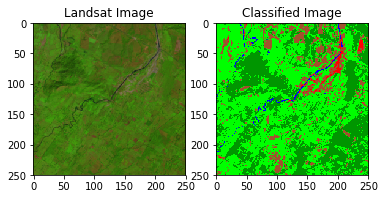

In [46]:
# Visualize

# First setup a 5-4-3 composite
def color_stretch(image, index, minmax=(0, 10000)):
    colors = image[:, :, index].astype(np.float64)

    max_val = minmax[1]
    min_val = minmax[0]

    # Enforce maximum and minimum values
    colors[colors[:, :, :] > max_val] = max_val
    colors[colors[:, :, :] < min_val] = min_val

    for b in range(colors.shape[2]):
        colors[:, :, b] = colors[:, :, b] * 1 / (max_val - min_val)
        
    return colors
    
img543 = color_stretch(img, [4, 3, 2], (0, 8000))

# See https://github.com/matplotlib/matplotlib/issues/844/
n = class_prediction.max()
# Next setup a colormap for our map
colors = dict((
    (0, (0, 0, 0, 255)),  # Nodata
    (1, (0, 150, 0, 255)),  # Forest
    (2, (0, 0, 255, 255)),  # Water
    (3, (0, 255, 0, 255)),  # Herbaceous
    (4, (160, 82, 45, 255)),  # Barren
    (5, (255, 0, 0, 255))  # Urban
))
# Put 0 - 255 as float 0 - 1
for k in colors:
    v = colors[k]
    _v = [_v / 255.0 for _v in v]
    colors[k] = _v
    
index_colors = [colors[key] if key in colors else 
                (255, 255, 255, 0) for key in range(1, n + 1)]
cmap = plt.matplotlib.colors.ListedColormap(index_colors, 'Classification', n)

# Now show the classmap next to the image
plt.subplot(121)
plt.imshow(img543)
plt.title('Landsat Image')
print(class_prediction.shape)
plt.subplot(122)
plt.imshow(class_prediction, cmap=cmap, interpolation='none')
plt.title('Classified Image')

plt.show()

## Wrapup

We've seen how we can use `scikit-learn` to implement the Random Forest classifier for land cover classification. 

We've seen how Random Forest can come up with an estimate of the classification accuracy using the "Out-of-Bag" samples. 